In [4]:
import numpy as np 
import os
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import random
f

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
''' name of directorires '''
os.listdir("../Sheep Breed Classification using CNN DL/SheepFaceImages")

['Marino', 'Poll Dorset', 'Suffolk', 'White Suffolk']

In [6]:
''' path of following class '''
marino = "../Sheep Breed Classification using CNN DL/SheepFaceImages/Marino/"
white_suffolk = "../Sheep Breed Classification using CNN DL/SheepFaceImages/White Suffolk"
poll_dorset = "../Sheep Breed Classification using CNN DL/SheepFaceImages/Poll Dorset"
suffolk = "../Sheep Breed Classification using CNN DL/SheepFaceImages/Suffolk"

In [7]:
''' Creating Dataset '''
X = []
y = []

def dataset(dir_name, breed_name):
    X_local, y_local = [], []
    for i in tqdm(os.listdir(dir_name), desc=f"Loading {breed_name}"):
        p = os.path.join(dir_name, i)
        try:
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.resize(img, (150, 150))
        except:
            continue
        X_local.append(img)
        y_local.append(breed_name)
    return X_local, y_local

In [8]:
''' Calling dataset function to create data for each class '''
for breed_name, dir_path in [
    ("Marino", marino),
    ("White Suffolk", white_suffolk),
    ("Poll Dorset", poll_dorset),
    ("Suffolk", suffolk)
]:
    X_batch, y_batch = dataset(dir_path, breed_name)
    X.extend(X_batch)
    y.extend(y_batch)

Loading Suffolk: 100%|███████████████████████████████████████████████████████████████| 226/226 [00:02<00:00, 99.73it/s]


In [9]:
''' converting images to numpy'''
X = np.array(X)
y = np.array(y)

''' checking shape of images '''
print(X.shape,y.shape)

(1158, 150, 150, 3) (1158,)


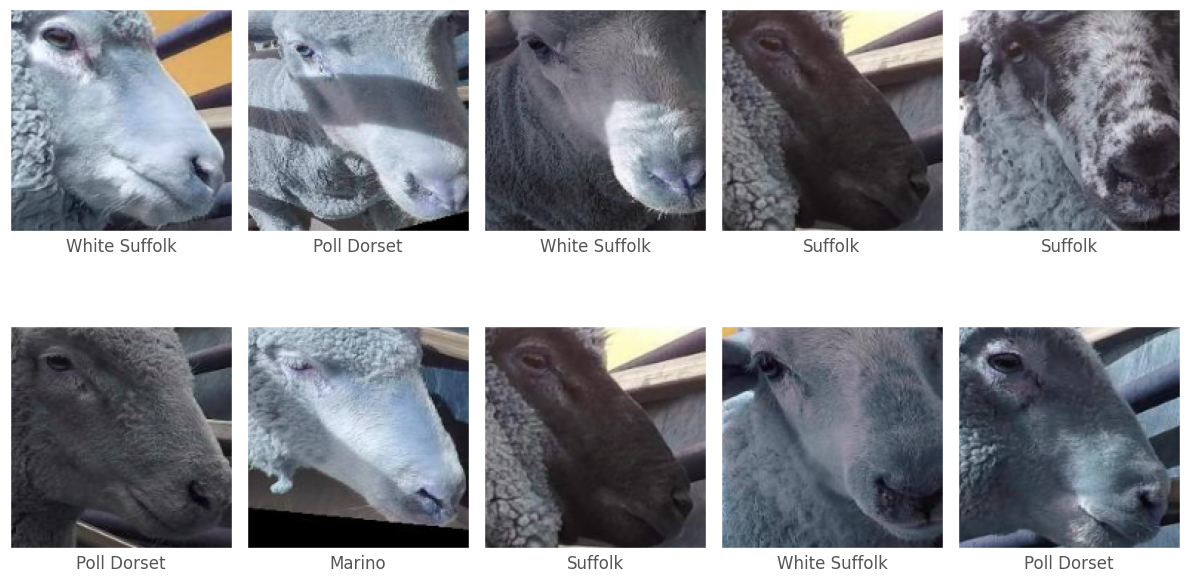

In [80]:
''' plotting some images '''

plt.figure(figsize=(12, 7))  # Create one figure

for i in range(10):
    idx = random.randint(0, len(y)-1)
    img = X[idx]
    plt.subplot(2, 5, i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(img)
    plt.xlabel(y[idx])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

    

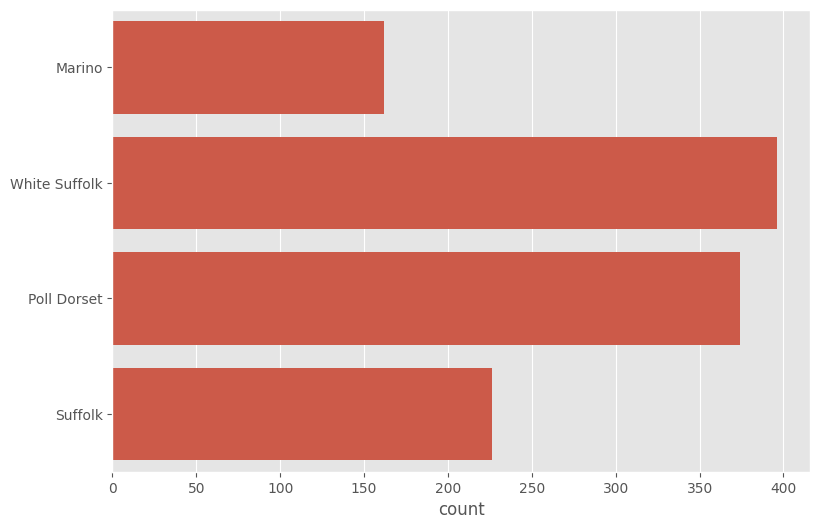

In [11]:
''' barplot of classes '''
plt.style.use("ggplot")
plt.figure(figsize=(9,6))
sns.countplot(y)
plt.show()

In [12]:
''' doing label encoding in class y and conerting it into to_categorical '''
le = LabelEncoder()
y_int = le.fit_transform(y)

In [13]:
''' train teset split '''
X_train, X_test, y_train_int, y_test_int = train_test_split(
    X, y_int,
    test_size=0.2,
    stratify=y_int,
    random_state=42
)

In [14]:
'''One Hot Encoding'''
y_train = to_categorical(y_train_int, num_classes=len(le.classes_))
y_test  = to_categorical(y_test_int, num_classes=len(le.classes_))

In [15]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (926, 150, 150, 3)
y_train shape: (926, 4)
X_test shape: (232, 150, 150, 3)
y_test shape: (232, 4)


In [16]:
''' Model ResNet50 '''
resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(150,150,3))

In [17]:
''' freezing layers '''
for l in resnet_model.layers:
    l.trainable = False

In [18]:
''' Final Model '''

''' container '''
model = Sequential()

''' resnet model '''
model.add(resnet_model)

''' flattening input to convert it into 1D'''
model.add(Flatten())

''' classificaion layer '''
model.add(Dense(4,activation = "softmax"))

''' lets see how model looks like '''
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │         204,804 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,792,516 (90.76 MB)

 Trainable params: 204,804 (800.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
''' EarlyStopping and Checkpoint'''
cp = ModelCheckpoint("resnet50.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
es = EarlyStopping(monitor="val_accuracy",patience=8,verbose=1)

''' compile the model '''
model.compile(optimizer="adam",loss = "categorical_crossentropy",metrics = ["accuracy"])

In [20]:
''' training '''
history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=25, verbose=1, 
                    callbacks = [cp, es])

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3905 - loss: 14.6569  
Epoch 1: val_accuracy improved from -inf to 0.67672, saving model to resnet50.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.3981 - loss: 14.4400 - val_accuracy: 0.6767 - val_loss: 4.4405
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8121 - loss: 2.2736 
Epoch 2: val_accuracy improved from 0.67672 to 0.85776, saving model to resnet50.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8151 - loss: 2.2249 - val_accuracy: 0.8578 - val_loss: 1.4994
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9299 - loss: 0.6092 
Epoch 3: val_accuracy improved from 0.85776 to 0.91379, saving model to resnet50.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.9313 - loss: 0.5919 - val_accuracy: 0.9138 - val_loss: 0.9606
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9844 - loss: 0.0645 
Epoch 4: val_accuracy improved from 0.91379 to 0.93534, saving model to resnet50.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9845 - loss: 0.0637 - val_accuracy: 0.9353 - val_loss: 0.6453
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9978 - loss: 0.0048     
Epoch 5: val_accuracy improved from 0.93534 to 0.94828, saving model to resnet50.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9978 - loss: 0.0049 - val_accuracy: 0.9483 - val_loss: 0.6407
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9994 - loss: 0.0021     
Epoch 6: val_accuracy did not improve from 0.94828
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9224 - val_loss: 0.7312
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 2.2954e-04 
Epoch 7: val_accuracy did not improve from 0.94828
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 1.0000 - loss: 2.2610e-04 - val_accuracy: 0.9310 - val_loss: 0.7932
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 1.0000 - loss: 2.1029e-04 
Epoch 8: val_accuracy did not improve from 0.94828
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 1.0000 - loss: 2.0871e-04 - val_accuracy: 0.9267 - val_loss: 0.7920
Epoch 9/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 6.9564e-05 
Epoch 9: val_accuracy did n

In [21]:
''' evaluaing the model '''
l, acc = model.evaluate(X_test,y_test)
print(f"Loss for resnet50: {l}")
print(f"Accuracy for resnet50: {acc}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9428 - loss: 0.5942
Loss for resnet50: 0.7341705560684204
Accuracy for resnet50: 0.9396551847457886


In [22]:
''' prediction '''
y_probs = model.predict(X_test) 

''' Get predicted class indices (argmax of probabilities) '''
y_pred = np.argmax(y_probs, axis=1)

''' Show first 15 predicted class indices '''
print(y_pred[:15])

8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
[2 3 1 3 2 0 2 2 3 1 3 2 1 1 3]


In [23]:
y_test_resnet = np.argmax(y_test,axis=1)

''' displaying first 15 actual values '''
y_test_resnet[:15]

array([2, 3, 1, 3, 2, 0, 2, 2, 3, 1, 0, 2, 1, 1, 3], dtype=int64)

In [24]:
''' classification report '''
print(classification_report(y_test_resnet,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79        33
           1       0.93      0.99      0.95        75
           2       0.98      0.98      0.98        45
           3       0.94      0.97      0.96        79

    accuracy                           0.94       232
   macro avg       0.94      0.91      0.92       232
weighted avg       0.94      0.94      0.94       232



In [25]:
''' VGG19 Model'''
vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(150,150,3))

In [26]:
''' freezing layers '''
for l in vgg_model.layers:
    l.trainable = False

In [27]:
''' container '''
model2 = Sequential()

''' vgg model '''
model2.add(vgg_model)

''' flattening input to convert it into 1D '''
model2.add(Flatten())

''' classification layer '''
model2.add(Dense(4,activation = "softmax"))

''' lets see how model looks like '''
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │          32,772 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,057,156 (76.51 MB)

 Trainable params: 32,772 (128.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [28]:
''' EarlyStopping and Checkpoint '''
cp2 = ModelCheckpoint("vgg19.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)
es2 = EarlyStopping(monitor="val_accuracy",patience=8,verbose=1)

''' compile the model '''
model2.compile(optimizer="adam",loss = "categorical_crossentropy",metrics = ["accuracy"])

''' training '''
history2 = model2.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=25, verbose=1, 
                      callbacks = [cp2,es2])

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3967 - loss: 16.3053  
Epoch 1: val_accuracy improved from -inf to 0.73707, saving model to vgg19.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.4053 - loss: 15.9335 - val_accuracy: 0.7371 - val_loss: 3.0572
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8370 - loss: 2.1419  
Epoch 2: val_accuracy improved from 0.73707 to 0.87069, saving model to vgg19.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 145s 10s/step - accuracy: 0.8387 - loss: 2.1173 - val_accuracy: 0.8707 - val_loss: 1.5956
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9471 - loss: 0.3691  
Epoch 3: val_accuracy improved from 0.87069 to 0.88793, saving model to vgg19.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 151s 10s/step - accuracy: 0.9475 - loss: 0.3640 - val_accuracy: 0.8879 - val_loss: 1.3206
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9797 - loss: 0.1075  
Epoch 4: val_accuracy did not improve from 0.88793
15/15 ━━━━━━━━━━━━━━━━━━━━ 145s 10s/step - accuracy: 0.9799 - loss: 0.1056 - val_accuracy: 0.8836 - val_loss: 1.3425
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9822 - loss: 0.0531  
Epoch 5: val_accuracy improved from 0.88793 to 0.91379, saving model to vgg19.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 147s 10s/step - accuracy: 0.9827 - loss: 0.0522 - val_accuracy: 0.9138 - val_loss: 0.9476
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9942 - loss: 0.0235   
Epoch 6: val_accuracy did not improve from 0.91379
15/15 ━━━━━━━━━━━━━━━━━━━━ 150s 10s/step - accuracy: 0.9943 - loss: 0.0229 - val_accuracy: 0.9052 - val_loss: 0.9414
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9994 - loss: 0.0018       
Epoch 7: val_accuracy did not improve from 0.91379
15/15 ━━━━━━━━━━━━━━━━━━━━ 143s 10s/step - accuracy: 0.9993 - loss: 0.0019 - val_accuracy: 0.8922 - val_loss: 1.0060
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 1.0000 - loss: 2.7355e-04  
Epoch 8: val_accuracy did not improve from 0.91379
15/15 ━━━━━━━━━━━━━━━━━━━━ 145s 10s/step - accuracy: 1.0000 - loss: 2.7454e-04 - val_accuracy: 0.9052 - val_loss: 1.0134
Epoch 9/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 2.2395e-04  
Epoch 9: val_accuracy

In [29]:
''' evaluating the model '''
l2, acc2 = model2.evaluate(X_test,y_test)
print(f"Loss for vgg19: {l2}")
print(f"Accuracy for vgg19: {acc2}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8999 - loss: 1.0727
Loss for vgg19: 0.9758174419403076
Accuracy for vgg19: 0.9008620977401733


In [54]:
''' prediction '''
y_probs2 = model2.predict(X_test)  # shape: (n_samples, n_classes)

# 2. Get predicted class indices (argmax of probabilities)
y_pred2 = np.argmax(y_probs2, axis=1)

# 3. Show first 15 predicted class indices
print(y_pred2[:15])

8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step
[2 3 1 3 2 0 2 2 3 1 0 2 1 1 3]


In [56]:
y_test_vgg = np.argmax(y_test,axis=1)

''' displaying first 15 actual values '''
y_test_vgg[:15]

array([2, 3, 1, 3, 2, 0, 2, 2, 3, 1, 0, 2, 1, 1, 3], dtype=int64)

In [57]:
''' classification report '''
print(classification_report(y_test_vgg,y_pred2))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78        33
           1       0.89      0.93      0.91        75
           2       0.96      0.96      0.96        45
           3       0.95      0.89      0.92        79

    accuracy                           0.90       232
   macro avg       0.89      0.89      0.89       232
weighted avg       0.90      0.90      0.90       232



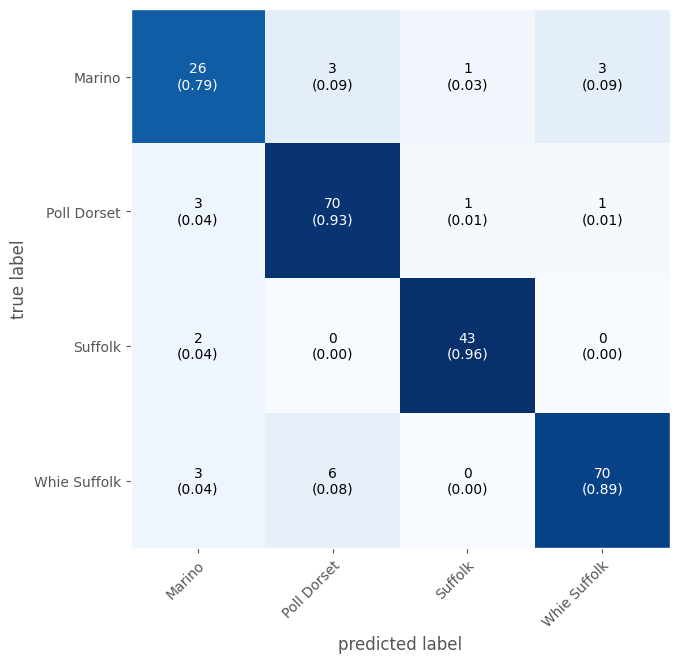

In [58]:
''' confusion matrix '''
cm = confusion_matrix(y_test_vgg,y_pred2)
plot_confusion_matrix(conf_mat=cm, show_normed=True, class_names = ["Marino","Poll Dorset","Suffolk",
                                                                    "Whie Suffolk"],figsize=(8,7));

In [75]:
def plot_acc_loss_resnet(history, epochs):
    
    ''' Validation and Training accuracy graph'''
    plt.style.use("ggplot")
    plt.figure(figsize=(12,6))
    epochs = np.arange(1,epochs+1)
    plt.subplot(2,2,1)
    plt.plot(epochs,history.history["accuracy"],"go-")
    plt.plot(epochs,history.history["val_accuracy"],"ro-")
    plt.title("Model Accuracy Curve for ResNet50")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Val"],loc = "upper left")
    
    ''' Validation and Training loss graph'''
    plt.subplot(2,2,2)
    plt.plot(epochs,history.history["loss"],"go-")
    plt.plot(epochs,history.history["val_loss"],"ro-")
    plt.title("Model Loss Curve for ResNet50")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train","Val"],loc = "upper left")
    
    plt.show()
    

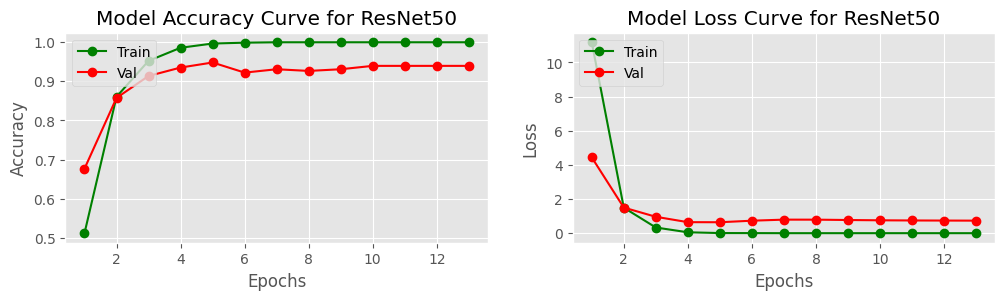

In [76]:
plot_acc_loss_resnet(history, 13)

In [77]:
def plot_acc_loss_vgg(history,epochs):   
    ''' Validation and Training accuracy graph'''
    plt.style.use("ggplot")
    plt.figure(figsize=(12,6))
    epochs = np.arange(1,epochs+1)
    plt.subplot(2,2,1)
    plt.plot(epochs, history.history["accuracy"],"go-")
    plt.plot(epochs, history.history["val_accuracy"],"ro-")
    plt.title("Model Accuracy Curve for VGG19")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Val"],loc = "upper left")
    
    ''' Validation and Training loss graph'''
    plt.subplot(2,2,2)
    plt.plot(epochs,history.history["loss"],"go-")
    plt.plot(epochs,history.history["val_loss"],"ro-")
    plt.title("Model Loss Curve for VGG19")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train","Val"],loc = "upper left")
    plt.show()

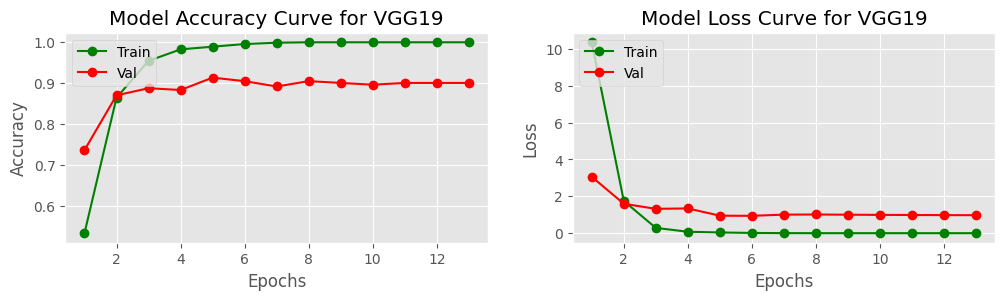

In [78]:
plot_acc_loss_vgg(history2, 13)